# DMD (for batch)
similar to the easy model setup it will be attempted to create a DMD model for the System dynamics. 
However this time, DMD might be a lot better suited, since the system dimension is also a lot bigger than for the "simple" bioreactor model
The data is used to find a best fit linear operator for the approximation of the nonlinear system such that
$$x_{k+1}=A\cdot x_{k}$$

The practical computation uses the singular value decomposition of the snapshot matrices  
SVD of $X = U \Sigma V^T$ and $X' = A X = A U \Sigma V^T$

To solve for $A$, use the pseudoinverse:
$$
A = X' V \Sigma^{-1} U^T
$$

Where:
- $X = [x_1, ..., x_{m-1}]$ (data matrix of snapshots)
- $X' = [x_2, ..., x_m]$ (data matrix shifted by one step)
- $U, \Sigma, V^T$ are from the SVD of $X$.

This gives the best-fit linear operator $A$ such that $x_{k+1} \approx A x_k$.


In [46]:
#imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math
from functools import partial
import pickle
import torch
import torch.nn as nn
from Training_helper import *
import pandas as pd
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data import

In [47]:

with open("Dataset_training_integro_diff_Batch.pkl", "rb") as f:
    Dataset = pickle.load(f)


first = next(iter(Dataset.values()))
M, T = first["n"].shape
dim=M+1  # +1 for S
t_span=(0,0.1*T)
t_eval= torch.linspace(*t_span,T)
m=torch.linspace(0,2e-10,M, dtype=torch.float32)
delta_m=(m[1]-m[0]).item()
m_max=m[-1]

n_max = max(torch.tensor(entry["n"], dtype=torch.float32).max() for entry in Dataset.values())
S_max = 5   #max possible substrate

X_all, Y_all = [], []

for entry in Dataset.values():
    n = torch.tensor(entry["n"], dtype=torch.float32)  # (M, T)
    s = torch.tensor(entry["S"], dtype=torch.float32)  # (T,)

    n_norm = n / n_max#torch.log1p(n) / log_n_max                # log scaling
    s_norm = s / S_max         

    # X_t = [n(t), s(t)]
    X = torch.cat([n_norm[:, :-1], s_norm[:-1].unsqueeze(0)], dim=0).T   # shape (T-1, M+1)
    # Y_t = [n(t+1), s(t+1)]
    Y = torch.cat([n_norm[:, 1:],  s_norm[1:].unsqueeze(0)], dim=0).T    # shape (T-1, M+1)

    X_all.append(X)
    Y_all.append(Y)

# final stacked tensors
X_train = torch.cat(X_all, dim=0)  # shape: (total_samples, M+1)
Y_train = torch.cat(Y_all, dim=0)  # shape: (total_samples, M+1)


#validation set containing 1 dataset used for plotting
with open("Dataset_validation_integro_diff_Batch_for_plots.pkl", "rb") as f:
    Dataset_validation = pickle.load(f)

n0 = torch.tensor(Dataset_validation[0]["n"][:, 0], dtype=torch.float32)   # (M,)
S0 = torch.tensor(Dataset_validation[0]["initial_substrate"], dtype=torch.float32)

#validation set containing 147 datasets used for error estimation over a broad range of parameters
with open("Dataset_validation_integro_diff_Batch.pkl","rb") as f:
    Dataset_error_est=pickle.load(f)


# DMD

In [48]:

#snapshot matrices
X_DMD = X_train.T       # shape: (d, N)
Y = Y_train.T           # shape: (d, N)

#Singular Value Decomposition
U, S, Vh = torch.linalg.svd(X_DMD, full_matrices=False)

# choose truncation rank
r = 20

#reduced matrices
U_r = U[:, :r]
S_r = S[:r]
Vh_r = Vh[:r, :]

Sigma_r_inv = torch.diag(1.0 / S_r)

# reduced operator (r x r)
A_tilde = U_r.T @ Y @ Vh_r.T @ Sigma_r_inv

#------------Validation rollout ---------------


# normalized initial state
x0_norm = torch.cat([n0 / n_max, (S0 / S_max).unsqueeze(0)], dim=0)  # (M+1,)

# project into reduced space
z0 = U_r.T @ x0_norm   # (r,)

# allocate reduced trajectory
T_val = Dataset_validation[0]["n"].shape[1]
z_pred = torch.zeros((T_val, r))
z_pred[0] = z0

for k in range(T_val - 1):
    z_pred[k+1] = A_tilde @ z_pred[k]

# lift back to full space
x_pred_norm = (U_r @ z_pred.T).T   # (T, M+1)

# rescale
n_pred = x_pred_norm[:, :M] * n_max
S_pred = x_pred_norm[:, -1] * S_max




## Plotting (+visualization of validation example)

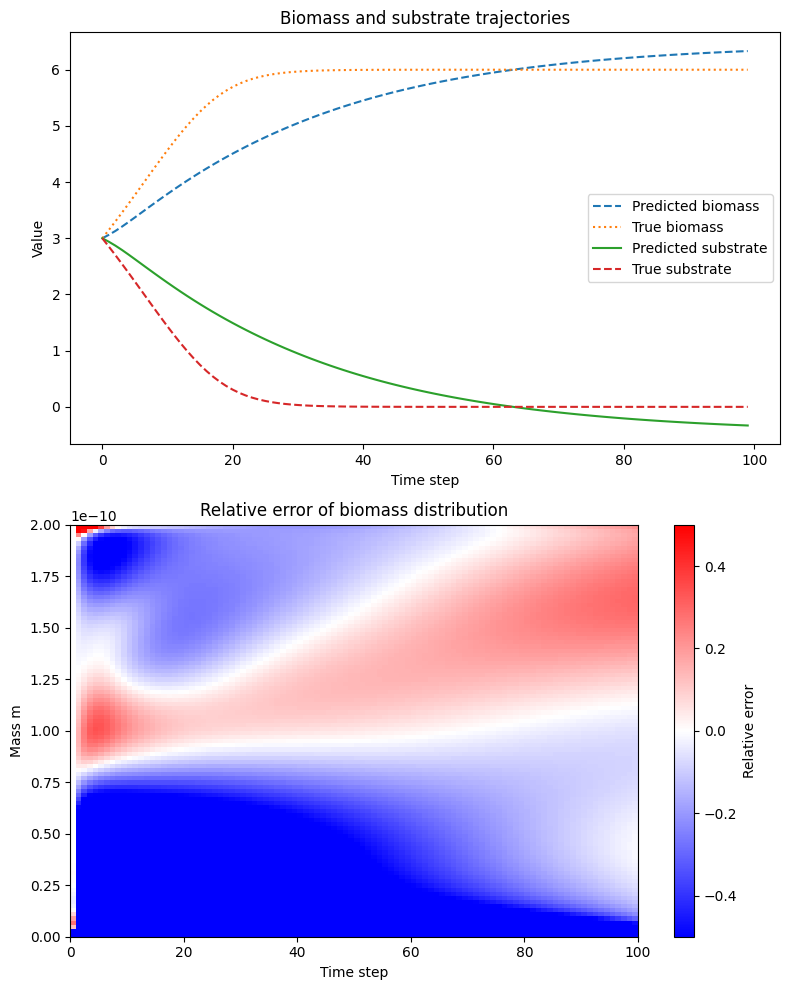

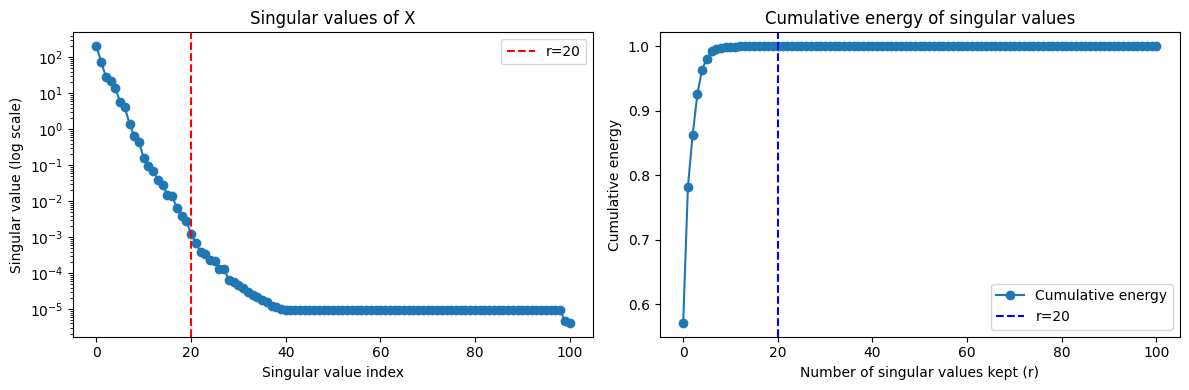

In [49]:


# -----------------------------
# 4. Error estimation
# -----------------------------
n_true = torch.tensor(Dataset_validation[0]["n"].T, dtype=torch.float32)   # (T, M)
S_true = torch.tensor(Dataset_validation[0]["S"], dtype=torch.float32)     # (T,)

# -----------------------------
# 5. Plot biomass + substrate trajectory
# -----------------------------
plot_spaghetti(m,t_eval,n_pred.detach().numpy().T)
biomass_pred = (n_pred * m) .sum(dim=1) * delta_m   # shape (T,)
biomass_true = (n_true * m).sum(dim=1) * delta_m   # shape (T,)
# -----------------------------
# FIGURE 1: Trajectories + Heatmap
# -----------------------------
fig, axes = plt.subplots(2, 1, figsize=(8,10))

# (1a) Biomass + substrate trajectories
ax = axes[0]
ax.plot(biomass_pred.numpy(), label="Predicted biomass", linestyle="--")
ax.plot(biomass_true.numpy(), label="True biomass", linestyle=":")
ax.plot(S_pred.numpy(), label="Predicted substrate")
ax.plot(S_true.numpy(), label="True substrate", linestyle="--")
ax.set_xlabel("Time step")
ax.set_ylabel("Value")
ax.set_title("Biomass and substrate trajectories")
ax.legend()

# (1b) Relative error heatmap
ax = axes[1]
eps = 1e-12
rel_err_matrix = ((n_pred - n_true) / (n_true + eps)).detach().cpu().numpy()
im = ax.imshow(rel_err_matrix.T, aspect="auto", origin="lower",
               extent=[0, T_val, m[0].item(), m[-1].item()],
               cmap="bwr", vmin=-0.5, vmax=0.5)
fig.colorbar(im, ax=ax, label="Relative error")
ax.set_xlabel("Time step")
ax.set_ylabel("Mass m")
ax.set_title("Relative error of biomass distribution")

plt.tight_layout()
plt.show()


# -----------------------------
# FIGURE 2: Singular values + Cumulative energy
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# (2a) Singular values
ax = axes[0]
ax.semilogy(S.numpy(), 'o-')
ax.axvline(r, color="red", linestyle="--", label=f"r={r}")
ax.set_xlabel("Singular value index")
ax.set_ylabel("Singular value (log scale)")
ax.set_title("Singular values of X")
ax.legend()

# (2b) Cumulative singular value energy
ax = axes[1]
sing_energy = torch.cumsum(S, dim=0) / torch.sum(S)
ax.plot(sing_energy.numpy(), 'o-', label="Cumulative energy")
ax.axvline(r, color="blue", linestyle="--", label=f"r={r}")
ax.set_xlabel("Number of singular values kept (r)")
ax.set_ylabel("Cumulative energy")
ax.set_title("Cumulative energy of singular values")
ax.legend()

plt.tight_layout()
plt.show()


## Error visualization for all validation sets
Trying to find model bias by taking the error estimation for all datasets


      id  initial_biomass  initial_substrate     err_n     err_S
0      0            0.425           0.333333  0.716761  0.428116
1      1            0.425           0.333333  0.496377  0.512302
2      2            0.425           0.333333  0.467371  0.374766
3      3            0.425           1.000000  0.614350  0.162112
4      4            0.425           1.000000  0.328141  0.284657
..   ...              ...                ...       ...       ...
103  103            3.675           3.000000  0.272229  0.846002
104  104            3.675           3.000000  0.426253  1.295383
105  105            3.675           3.666667  0.716157  2.010087
106  106            3.675           3.666667  0.249939  0.808096
107  107            3.675           3.666667  0.407147  1.167357

[108 rows x 5 columns]
   id  initial_biomass  initial_substrate     err_n     err_S
0   0            0.425           0.333333  0.716761  0.428116
1   1            0.425           0.333333  0.496377  0.512302
2   2     

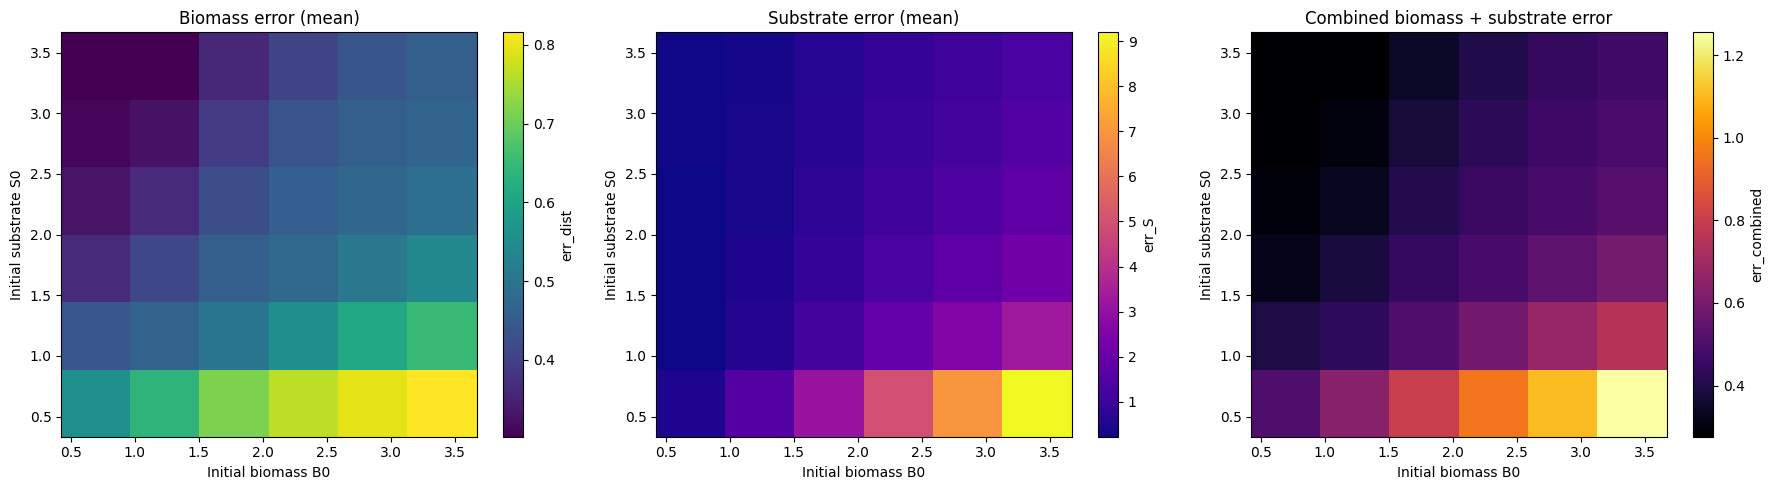

In [50]:
def dmd_rollout(entry, A, n_max, S_max,m,delta_m, U_r=None):
    """
    Perform a DMD rollout for one dataset entry.

    Parameters
    ----------
    entry : dict
        One dataset entry containing fields:
        - "n": biomass array (M x T)
        - "S": substrate array (T,)
        - "initial_substrate": float
    A : torch.Tensor
        Learned DMD operator (either full or reduced).
    n_max : float
        Normalization factor for biomass.
    S_max : float
        Normalization factor for substrate.
    U_r : torch.Tensor, optional
        Basis for reduced DMD (if using truncated SVD).
        If None, assumes full DMD.

    Returns
    -------
    n_pred : torch.Tensor (T, M)
        Predicted biomass distribution.
    S_pred : torch.Tensor (T,)
        Predicted substrate trajectory.
    err_n : float
        Relative biomass error.
    err_S : float
        Relative substrate error.
    """

    n_true = torch.tensor(entry["n"].T, dtype=torch.float32)   # (T, M)
    S_true = torch.tensor(entry["S"], dtype=torch.float32)     # (T,)
    T, M = n_true.shape

    # initial condition
    n0 = n_true[0]
    S0 = S_true[0]

    # normalize
    x0_norm = torch.cat([n0 / n_max, (S0 / S_max).unsqueeze(0)], dim=0)  # (M+1,)
    

    if U_r is not None:
        # project into reduced space
        z0 = U_r.T @ x0_norm
        z_pred = torch.zeros((T, len(z0)))
        z_pred[0] = z0
        for k in range(T-1):
            z_pred[k+1] = A @ z_pred[k]
        x_pred_norm = (U_r @ z_pred.T).T
    else:
        # full DMD
        x_pred_norm = torch.zeros((T, M+1))
        x_pred_norm[0] = x0_norm
        for k in range(T-1):
            x_pred_norm[k+1] = A @ x_pred_norm[k]

    # rescale back
    n_pred = x_pred_norm[:, :M] * n_max
    S_pred = x_pred_norm[:, -1] * S_max
   

    n_pred = n_pred.to(torch.float64)
    n_true = n_true.to(torch.float64)
    # errors
    eps = 1e-12
    err_n = torch.norm((n_pred - n_true)*m*delta_m) / (torch.norm(n_true*m*delta_m)+eps)
    err_S = torch.norm(S_pred - S_true) / (torch.norm(S_true) + eps)

    return n_pred, S_pred, err_n.item(), err_S.item()




# --- Run rollout over all validation datasets ---
results = []

for idx, entry in Dataset_error_est.items():
    n_pred, S_pred, err_n, err_S = dmd_rollout(entry, A_tilde, n_max, S_max,m=m,delta_m=delta_m, U_r=U_r)  # or U_r=U_r if reduced

    results.append({
        "id": idx,
        "initial_biomass": entry["initial biomass"],
        "initial_substrate": entry["initial_substrate"],
        "err_n": err_n,
        "err_S": err_S
    })

# --- Put into DataFrame ---
df_results = pd.DataFrame(results)
print(df_results)
print(df_results.head())
print("\nError statistics:")
print(df_results[["err_n", "err_S"]].describe())


# --- Aggregate across replicates (mean + std) ---
pivot_n_mean = df_results.pivot_table(
    index="initial_substrate", columns="initial_biomass",
    values="err_n", aggfunc="mean"
)
pivot_S_mean = df_results.pivot_table(
    index="initial_substrate", columns="initial_biomass",
    values="err_S", aggfunc="mean"
)

pivot_n_std = df_results.pivot_table(
    index="initial_substrate", columns="initial_biomass",
    values="err_n", aggfunc="std"
)
pivot_S_std = df_results.pivot_table(
    index="initial_substrate", columns="initial_biomass",
    values="err_S", aggfunc="std"
)

# --- Aggregate biomass + substrate error together (normalized) ---
df_results["err_combined"] = (
    df_results["err_n"] / df_results["err_n"].max()
    + df_results["err_S"] / df_results["err_S"].max()
)

pivot_comb_mean_dmd = df_results.pivot_table(
    index="initial_substrate", columns="initial_biomass",
    values="err_combined", aggfunc="mean"
)

# --- Plot all three heatmaps ---
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# (1) Distribution error
im1 = axes[0].imshow(pivot_n_mean.values, origin="lower", aspect="auto",
                     extent=[pivot_n_mean.columns.min(), pivot_n_mean.columns.max(),
                             pivot_n_mean.index.min(), pivot_n_mean.index.max()],
                     cmap="viridis")
axes[0].set_title("Biomass error (mean)")
axes[0].set_xlabel("Initial biomass B0")
axes[0].set_ylabel("Initial substrate S0")
fig.colorbar(im1, ax=axes[0], label="err_dist")

# (2) Substrate error
im2 = axes[1].imshow(pivot_S_mean.values, origin="lower", aspect="auto",
                     extent=[pivot_S_mean.columns.min(), pivot_S_mean.columns.max(),
                             pivot_S_mean.index.min(), pivot_S_mean.index.max()],
                     cmap="plasma")
axes[1].set_title("Substrate error (mean)")
axes[1].set_xlabel("Initial biomass B0")
axes[1].set_ylabel("Initial substrate S0")
fig.colorbar(im2, ax=axes[1], label="err_S")

# (3) Combined biomass + substrate error
im3 = axes[2].imshow(pivot_comb_mean_dmd.values, origin="lower", aspect="auto",
                     extent=[pivot_comb_mean_dmd.columns.min(), pivot_comb_mean_dmd.columns.max(),
                             pivot_comb_mean_dmd.index.min(), pivot_comb_mean_dmd.index.max()],
                     cmap="inferno")
axes[2].set_title("Combined biomass + substrate error")
axes[2].set_xlabel("Initial biomass B0")
axes[2].set_ylabel("Initial substrate S0")
fig.colorbar(im3, ax=axes[2], label="err_combined")

plt.tight_layout()
plt.show()


# # --- (Optional) Plot std heatmaps for uncertainty ---
# fig, axes = plt.subplots(1, 2, figsize=(12,5))

# im1 = axes[0].imshow(pivot_n_std.values, origin="lower", aspect="auto",
#                      extent=[pivot_n_std.columns.min(), pivot_n_std.columns.max(),
#                              pivot_n_std.index.min(), pivot_n_std.index.max()],
#                      cmap="viridis")
# axes[0].set_title("Biomass error (std)")
# axes[0].set_xlabel("Initial biomass B0")
# axes[0].set_ylabel("Initial substrate S0")
# fig.colorbar(im1, ax=axes[0], label="err_n std")

# im2 = axes[1].imshow(pivot_S_std.values, origin="lower", aspect="auto",
#                      extent=[pivot_S_std.columns.min(), pivot_S_std.columns.max(),
#                              pivot_S_std.index.min(), pivot_S_std.index.max()],
#                      cmap="plasma")
# axes[1].set_title("Substrate error (std)")
# axes[1].set_xlabel("Initial biomass B0")
# axes[1].set_ylabel("Initial substrate S0")
# fig.colorbar(im2, ax=axes[1], label="err_S std")

# plt.tight_layout()
# plt.show()


# Extended DMD
EDMD does **not** try to approximate a mapping directly in state space. Instead:

1. **Feature map (dictionary):**  

$$
\phi : \mathbb{R}^d \to \mathbb{R}^D, 
\quad 
\phi(x) = \begin{bmatrix}
\phi_1(x) \\
\phi_2(x) \\
\vdots \\
\phi_D(x)
\end{bmatrix},
$$  

e.g.  

$$
\phi(x) = [\,x_1, \dots, x_d, x_1^2, \dots, x_d^2, \dots ]^\top.
$$  

---

2. **Linear dynamics in feature space:**  

$$
\phi(x_{k+1}) \;\approx\; K \, \phi(x_k),
$$  

where $ K \in \mathbb{R}^{D \times D} $ is the EDMD approximation of the Koopman operator.  

---

3. **Fitting equation:**  
Given lifted data matrices 
$$ 
\Phi_X = \phi(x_0), \; \phi(x_1), \; \dots, \; \phi(x_{m-1}),
$$  

$$
\Phi_Y = \phi(x_1), \; \phi(x_2), \; \dots, \; \phi(x_m).
$$  
the least-squares solution is  

$$
K = \Phi_Y \, \Phi_X^{+},
$$  

where \( \Phi_X^{+} \) is the  pseudoinverse.  

---

## Prediction
If the original state \(x\) is included as part of \(\phi(x)\) (e.g. in the first \(d\) components), then after evolving in feature space  

$$
\hat{\phi}_{k+1} = K \, \hat{\phi}_k,
$$  

the prediction for the physical state is obtained by projecting onto those components:  

$$
\hat{x}_{k+1} \;\approx\; \big[\, \hat{\phi}_{k+1} \,\big]_{1:d}.
$$  

In [55]:
import pickle
import torch
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load training data and build X, Y
# -----------------------------
# -----------------------------
# 2. Feature lifting: [n, S, S*n]
# ----------------------------

degree=7

Phi_X = EDMD_feature_space(X_train,degree=degree)  # (N, M + degree*(M+1))
Phi_Y = EDMD_feature_space(Y_train,degree=degree)  # (N, M + degree*(M+1))

# -----------------------------
# 3. Compute EDMD operator
# -----------------------------
#Transpose so time is the column dimension
Phi_XT = Phi_X.T    # (D, N)
Phi_YT = Phi_Y.T    # (D, N)

U, S, Vh = torch.linalg.svd(Phi_XT, full_matrices=False)

# truncation rank
r = 23
U_r = U[:, :r]
S_r = S[:r]
Vh_r = Vh[:r, :]

Sigma_r_inv = torch.diag(1.0 / S_r)

K_tilde = U_r.T @ Phi_YT @ Vh_r.T @ Sigma_r_inv   # (r, r)

# -----------------------------
# 4. Validation rollout
# -----------------------------

# normalized initial state
x0_norm = torch.cat([n0 / n_max, (S0 / S_max).unsqueeze(0)], dim=0) # (M+1,)

# lifted initial condition
phi0 = EDMD_feature_space(x0_norm.unsqueeze(0),degree=degree).squeeze(0)  # (2M+1,)

# project to reduced space
z0 = U_r.T @ phi0

T_val = Dataset_validation[0]["n"].shape[1]
z_pred = torch.zeros((T_val, r))
z_pred[0] = z0

for k in range(T_val - 1):
    z_pred[k+1] = K_tilde @ z_pred[k]

# lift back
Phi_pred = (U_r @ z_pred.T).T   # (T, 2M+1)

# -----------------------------
# 5. Extract predictions
# -----------------------------
# from features: [n, S, S*n,...]
n_pred = Phi_pred[:, :M] * n_max
S_pred = Phi_pred[:, M] * S_max


## Plotting (+visualization of approximation)

Relative error biomass: nan
Relative error substrate: 4.350e-02


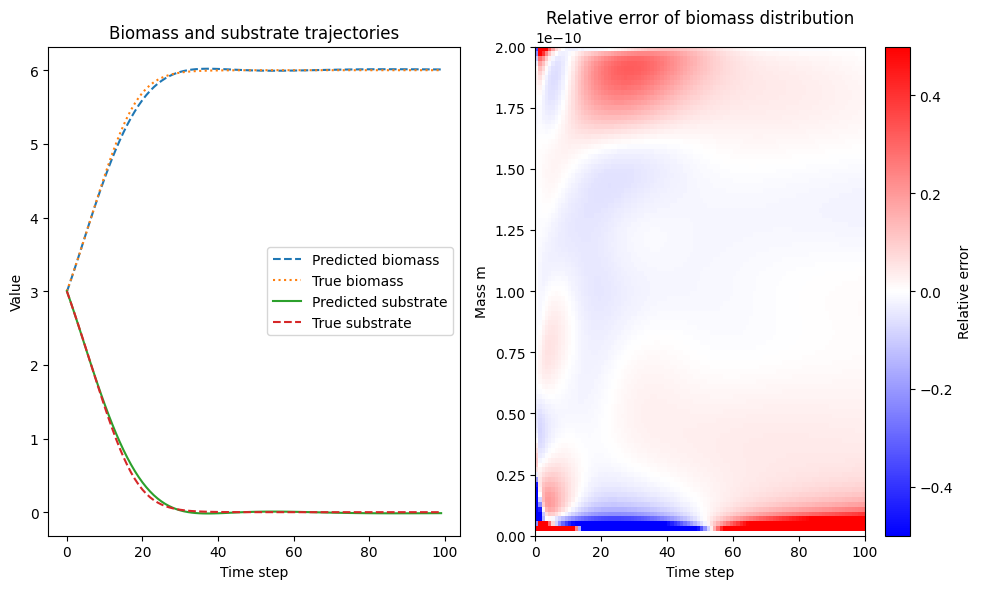

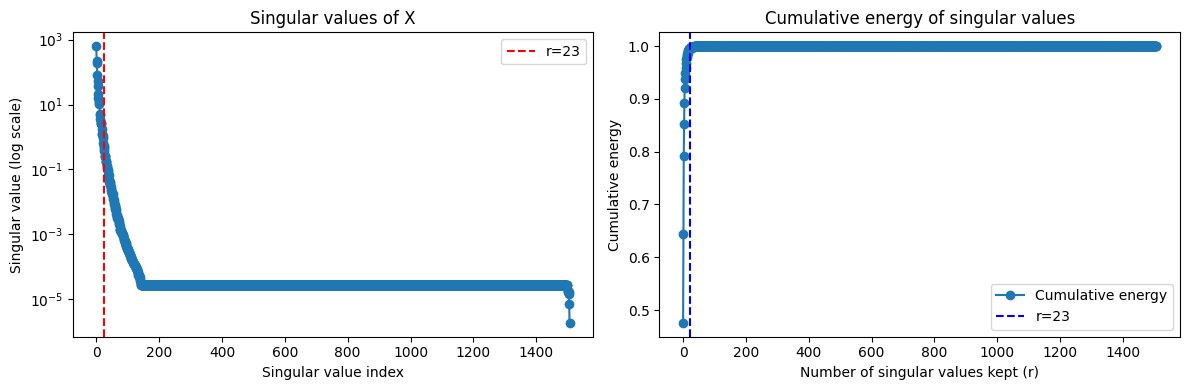

In [56]:
#plotting
n_true = torch.tensor(Dataset_validation[0]["n"].T, dtype=torch.float32)   # (T, M)
S_true = torch.tensor(Dataset_validation[0]["S"], dtype=torch.float32)     # (T,)

err_n = torch.norm(n_pred - n_true) / torch.norm(n_true)
err_S = torch.norm(S_pred - S_true) / torch.norm(S_true)

print(f"Relative error biomass: {err_n:.3e}")
print(f"Relative error substrate: {err_S:.3e}")

# -----------------------------
# 6. Plot results
# -----------------------------
plot_spaghetti(m,t_eval, n_pred.detach().numpy().T)
fig, axes = plt.subplots(1, 2, figsize=(10,6))

# (1a) Biomass + substrate trajectories
biomass_pred = (n_pred * m) .sum(dim=1) * delta_m   # shape (T,)
biomass_true = (n_true * m).sum(dim=1) * delta_m   # shape (T,)
ax = axes[0]
ax.plot(biomass_pred.numpy(), label="Predicted biomass", linestyle="--")
ax.plot(biomass_true.numpy(), label="True biomass", linestyle=":")
ax.plot(S_pred.numpy(), label="Predicted substrate")
ax.plot(S_true.numpy(), label="True substrate", linestyle="--")
ax.set_xlabel("Time step")
ax.set_ylabel("Value")
ax.set_title("Biomass and substrate trajectories")
ax.legend()

# (1b) Relative error heatmap
ax = axes[1]
eps = 1e-12
rel_err_matrix = ((n_pred - n_true) / (n_true + eps)).detach().cpu().numpy()
im = ax.imshow(rel_err_matrix.T, aspect="auto", origin="lower",
               extent=[0, T_val, m[0].item(), m[-1].item()],
               cmap="bwr", vmin=-0.5, vmax=0.5)
fig.colorbar(im, ax=ax, label="Relative error")
ax.set_xlabel("Time step")
ax.set_ylabel("Mass m")
ax.set_title("Relative error of biomass distribution")

plt.tight_layout()
plt.show()


# -----------------------------
# FIGURE 2: Singular values + Cumulative energy
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# (2a) Singular values
ax = axes[0]
ax.semilogy(S.numpy(), 'o-')
ax.axvline(r, color="red", linestyle="--", label=f"r={r}")
ax.set_xlabel("Singular value index")
ax.set_ylabel("Singular value (log scale)")
ax.set_title("Singular values of X")
ax.legend()

# (2b) Cumulative singular value energy
ax = axes[1]
sing_energy = torch.cumsum(S, dim=0) / torch.sum(S)
ax.plot(sing_energy.numpy(), 'o-', label="Cumulative energy")
ax.axvline(r, color="blue", linestyle="--", label=f"r={r}")
ax.set_xlabel("Number of singular values kept (r)")
ax.set_ylabel("Cumulative energy")
ax.set_title("Cumulative energy of singular values")
ax.legend()

plt.tight_layout()
plt.show()



## Error evaluation Extended DMD
in this part we will perform the same evaluation, as for DMD, but use the EDMD instead


initial_biomass       0.425     1.075     1.725     2.375     3.025     3.675
initial_substrate                                                            
0.333333           0.409605  0.073916  0.225013  0.326983  0.390124  0.447649
1.000000           0.240743  0.134875  0.279589  0.306931  0.257474  0.186302
1.666667           0.137280  0.237014  0.340554  0.327423  0.234702  0.114662
2.333333           0.111987  0.305438  0.364952  0.304711  0.163039  0.083765
3.000000           0.160136  0.359909  0.364176  0.242071  0.047050  0.257593
3.666667           0.266547  0.436104  0.367098  0.160797  0.159306  0.533721


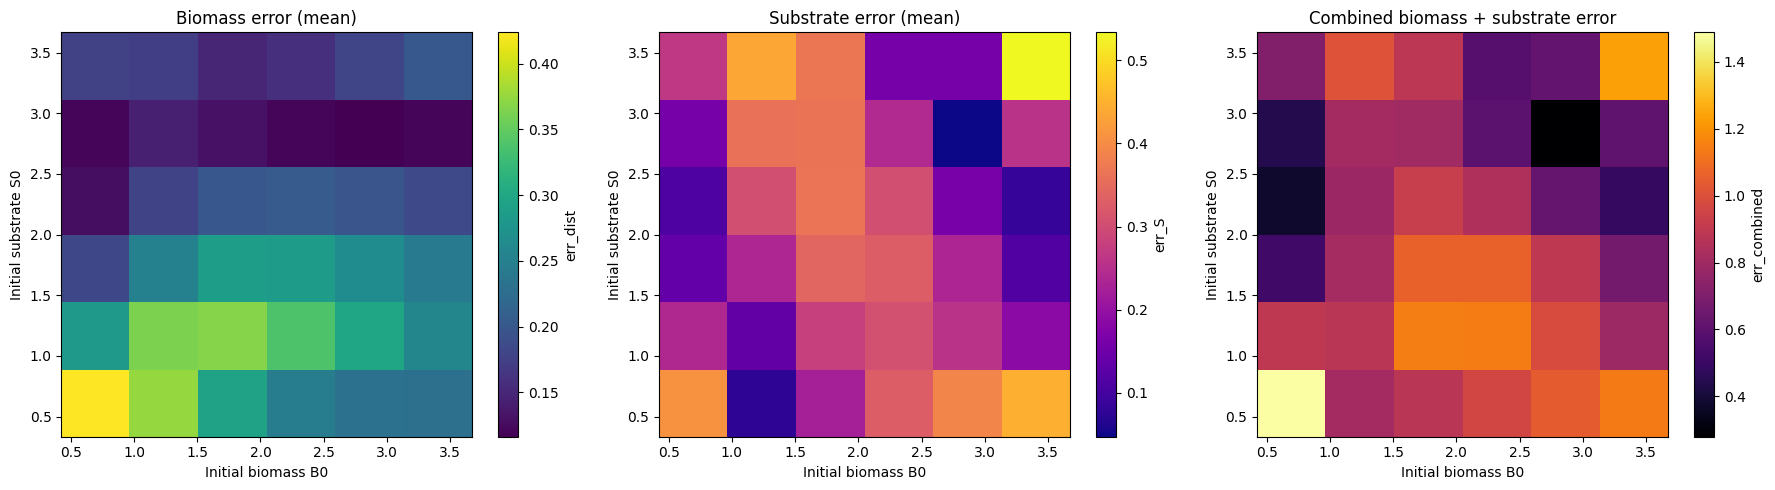

In [67]:
def edmd_rollout(entry, K_tilde, n_max, S_max, U_r, feature_fn, degree=3, delta_m=None, m=None):
    """
    Perform an EDMD rollout for one dataset entry.

    Parameters
    ----------
    entry : dict
        One dataset entry containing:
        - "n": biomass array (M x T)
        - "S": substrate array (T,)
    K_tilde : torch.Tensor
        Reduced EDMD operator (r x r).
    n_max : float
        Normalization factor for biomass.
    S_max : float
        Normalization factor for substrate.
    U_r : torch.Tensor
        Reduced basis (columns are singular vectors).
    feature_fn : function
        Function mapping X -> Phi(X) (the feature map).
    degree : int
        Polynomial degree (if applicable for feature_fn).
    delta_m : float, optional
        Mass grid spacing (needed if biomass error is requested).
    m : torch.Tensor, optional
        Mass grid vector (needed if biomass error is requested).

    Returns
    -------
    n_pred : torch.Tensor (T, M)
        Predicted biomass distribution.
    S_pred : torch.Tensor (T,)
        Predicted substrate trajectory.
    err_dist : float
        Relative distribution error.
    err_biomass : float
        Relative biomass error.
    err_S : float
        Relative substrate error.
    """

    n_true = torch.tensor(entry["n"].T, dtype=torch.float32)   # (T, M)
    S_true = torch.tensor(entry["S"], dtype=torch.float32)     # (T,)
    T, M = n_true.shape

    # initial condition
    n0 = n_true[0]
    S0 = S_true[0]

    # normalize
    x0_norm = torch.cat([n0 / n_max, (S0 / S_max).unsqueeze(0)], dim=0)  # (M+1,)

    # lift initial condition
    phi0 = feature_fn(x0_norm.unsqueeze(0), degree=degree).squeeze(0)  # (feature_dim,)

    # project into reduced space
    z0 = U_r.T @ phi0
    z_pred = torch.zeros((T, len(z0)))
    z_pred[0] = z0

    # rollout
    for k in range(T - 1):
        z_pred[k+1] = K_tilde @ z_pred[k]

    # lift back
    Phi_pred = (U_r @ z_pred.T).T   # (T, feature_dim)

    # extract predictions from features (assuming [n, S, interactions...])
    n_pred = Phi_pred[:, :M] * n_max
    S_pred = Phi_pred[:, M] * S_max

    # --- Error metrics ---
    eps = 1e-12
    n_pred = n_pred.to(torch.float64)
    n_true = n_true.to(torch.float64)

    # distribution error
    err_dist = torch.norm(n_pred - n_true) / (torch.norm(n_true) + eps)

    # biomass error (requires m, delta_m)
    if (m is not None) and (delta_m is not None):
        err_biomass = torch.norm((n_pred - n_true) * m * delta_m) / \
                      (torch.norm(n_true * m * delta_m) + eps)
    else:
        err_biomass = float("nan")

    # substrate error
    err_S = torch.norm(S_pred - S_true) / (torch.norm(S_true) + eps)

    return n_pred, S_pred, err_dist.item(), err_biomass.item(), err_S.item()

# --- Run EDMD rollout over all validation datasets ---
results_edmd = []

for idx, entry in Dataset_error_est.items():
    n_pred, S_pred, err_dist, err_biomass, err_S = edmd_rollout(
        entry,
        K_tilde,           # reduced EDMD operator
        n_max, S_max,
        U_r,               # reduced basis
        feature_fn=EDMD_feature_space,  # <-- your feature function
        degree=degree,  # polynomial degree for the feature space used in training
        delta_m=delta_m,
        m=m
    )

    results_edmd.append({
        "id": idx,
        "initial_biomass": entry["initial biomass"],
        "initial_substrate": entry["initial_substrate"],
        "err_dist": err_dist,
        "err_biomass": err_biomass,
        "err_S": err_S
    })

# --- Put into DataFrame ---
df_edmd = pd.DataFrame(results_edmd)
# print(df_edmd.head())
# print("\nError statistics:")
# print(df_edmd[["err_dist", "err_biomass", "err_S"]].describe())

# --- Aggregate across replicates (mean + std) ---
pivot_dist_mean = df_edmd.pivot_table(
    index="initial_substrate", columns="initial_biomass",
    values="err_dist", aggfunc="mean"
)
pivot_S_mean = df_edmd.pivot_table(
    index="initial_substrate", columns="initial_biomass",
    values="err_S", aggfunc="mean"
)
print(pivot_S_mean)

pivot_dist_std = df_edmd.pivot_table(
    index="initial_substrate", columns="initial_biomass",
    values="err_dist", aggfunc="std"
)
pivot_S_std = df_edmd.pivot_table(
    index="initial_substrate", columns="initial_biomass",
    values="err_S", aggfunc="std"
)

# --- Aggregate biomass + substrate error together (normalized) ---
df_edmd["err_combined"] = (
    df_edmd["err_biomass"] / df_edmd["err_biomass"].max()
    + df_edmd["err_S"] / df_edmd["err_S"].max()
)

pivot_comb_mean = df_edmd.pivot_table(
    index="initial_substrate", columns="initial_biomass",
    values="err_combined", aggfunc="mean"
)

# --- Plot all three heatmaps ---
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# (1) Distribution error
im1 = axes[0].imshow(pivot_dist_mean.values, origin="lower", aspect="auto",
                     extent=[pivot_dist_mean.columns.min(), pivot_dist_mean.columns.max(),
                             pivot_dist_mean.index.min(), pivot_dist_mean.index.max()],
                     cmap="viridis")
axes[0].set_title("Biomass error (mean)")
axes[0].set_xlabel("Initial biomass B0")
axes[0].set_ylabel("Initial substrate S0")
fig.colorbar(im1, ax=axes[0], label="err_dist")

# (2) Substrate error
im2 = axes[1].imshow(pivot_S_mean.values, origin="lower", aspect="auto",
                     extent=[pivot_S_mean.columns.min(), pivot_S_mean.columns.max(),
                             pivot_S_mean.index.min(), pivot_S_mean.index.max()],
                     cmap="plasma")
axes[1].set_title("Substrate error (mean)")
axes[1].set_xlabel("Initial biomass B0")
axes[1].set_ylabel("Initial substrate S0")
fig.colorbar(im2, ax=axes[1], label="err_S")

# (3) Combined biomass + substrate error
im3 = axes[2].imshow(pivot_comb_mean.values, origin="lower", aspect="auto",
                     extent=[pivot_comb_mean.columns.min(), pivot_comb_mean.columns.max(),
                             pivot_comb_mean.index.min(), pivot_comb_mean.index.max()],
                     cmap="inferno")
axes[2].set_title("Combined biomass + substrate error")
axes[2].set_xlabel("Initial biomass B0")
axes[2].set_ylabel("Initial substrate S0")
fig.colorbar(im3, ax=axes[2], label="err_combined")

plt.tight_layout()
plt.show()


